## 라이브러리 import

In [2]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, accuracy_score, log_loss, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


## 와인 품질 예측 !

<br>

<img 
     src="http://masism.kr/wp-content/uploads/2020/09/C-3.jpg">
     
<br>

<br>

## 데이터 로드

데이터는 train, test 데이터 모두 3231개의 행으로 이루어져 있습니다.

독립변수는 총 12개, 종속변수는 quality입니다.

In [3]:
train = pd.read_csv("./dataset/train.csv", index_col='id')
test = pd.read_csv("./dataset/test.csv", index_col='id')

display(train.shape, train.head(3), test.shape, test.head(3))

(3231, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
id,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,white,6
2,7.5,0.38,0.29,4.9,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,white,7
3,6.1,0.27,0.33,2.2,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,white,6


(3231, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
id,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.90,0.37,11.1,white
2,8.7,0.70,0.24,2.50,0.226,5.0,15.0,0.99910,3.32,0.60,9.0,red
3,6.9,0.63,0.01,2.40,0.076,14.0,39.0,0.99522,3.34,0.53,10.8,red


<br>


각각의 변수들에 대한 설명은 다음과 같습니다.

* id : 식별 고유값 --> 데이터의 인덱스로만 사용할 것입니다.

* fixed acidity : 고정(비휘발성) 산도: 와인과 관련된 대부분의 산

* volatile acidity : 휘발성 산도: 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

* citric acid : 구연산: 소량으로 발견되며, 와인에 풍미를 더할 수 있음

* residual sugar : 잔여 당분: 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

* chlorides : 염소화물: 와인의 염분량

* free sulfur dioxide : 유리 이산화황: 미생물의 성장과 와인의 산화를 방지함

* total sulfur dioxide : 총 이산화황: 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

* density : 밀도: 알코올 및 당 함량에 따라 변함

* pH : 산성 또는 염기성 정도. 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

* sulphates : 황산염: 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

* alcohol : 와인의 알코올 함량 백분율

* type : 와인에 사용된 포도의 종류. Red(적포도주), White(백포도주)로 나뉨

* quality : 맛으로 평가된 와인의 품질

<br>

## EDA


### 데이터 기본 정보


단순히 `train.info()` 만으로도 충분히 볼 수 있는 데이터이지만, 변수의 수가 100개가 넘는 데이터를 다룰 일들도 생길 것입니다.

변수의 수가 굉장히 많으면 `.info()` 메서드로는 출력이 안 될 수도 있는데요,

따라서 간단한 for문을 이용해서 각 변수의 고유한 값의 갯수까지 한 눈에 파악할 수 있도록 아래와 같이 구현해 보았습니다. 

In [4]:
train_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(train.columns)):
    train_info.loc[i] = [train.columns[i],
                        train[train.columns[i]].isnull().sum(),
                        train[train.columns[i]].dtypes,
                        train[train.columns[i]].nunique()]
    
train_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,99
1,volatile acidity,0,float64,159
2,citric acid,0,float64,86
3,residual sugar,0,float64,277
4,chlorides,0,float64,168
5,free sulfur dioxide,0,float64,115
6,total sulfur dioxide,0,float64,260
7,density,0,float64,806
8,pH,0,float64,105
9,sulphates,0,float64,101


In [5]:
test_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(test.columns)):
    test_info.loc[i] = [test.columns[i],
                        test[test.columns[i]].isnull().sum(),
                        test[test.columns[i]].dtypes,
                        test[test.columns[i]].nunique()]
    
test_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,92
1,volatile acidity,0,float64,159
2,citric acid,0,float64,84
3,residual sugar,0,float64,265
4,chlorides,0,float64,171
5,free sulfur dioxide,0,float64,106
6,total sulfur dioxide,0,float64,258
7,density,0,float64,816
8,pH,0,float64,100
9,sulphates,0,float64,97


<br>

1. null data는 없음

2. type컬럼만 object type. 향후 onehot encoding 또는 label encoding

<br>

<br>

### 종속변수의 분포

타겟변수인 quality의 불균형이 높은 편.

1. 4와 8은 각각 약 3%로 분포

2. 5와 6을 합쳐서 76.8%로 분포

3. 모델이 5와 6으로만 지나치게 예측할 가능성이 높음


<br>

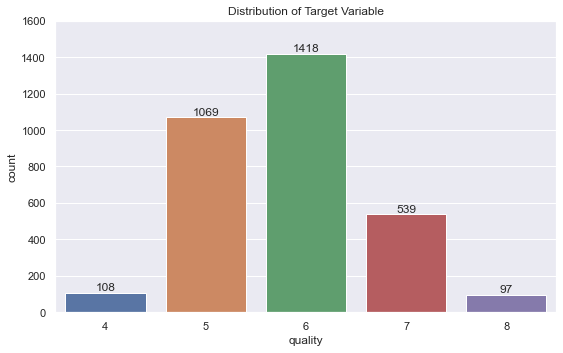

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(train['quality'])

ax.bar_label(ax.containers[0])
plt.title("Distribution of Target Variable")
ax.set_ylim(0, 1600)

plt.show()

In [7]:
train.quality.value_counts(normalize=True)

6    0.438873
5    0.330857
7    0.166821
4    0.033426
8    0.030022
Name: quality, dtype: float64

<br>

### 수치형 변수 분포

수치형 변수들의 분포를 train과 test 함께 비교해본 결과, train과 test가 거의 비슷하게 분포하고 있음을 알 수 있습니다.

왜도를 함께 확인한 결과, chlorides 변수를 제외하고는 치우침이 크지 않은 것으로 보입니다.(-2와 +2 사이가 기준)

변수 중에 치우친 변수가 있기 때문에 데이터 스케일링이 필요하다고 판단됩니다.



In [8]:
num_cols = list(train._get_numeric_data().columns[:-1])
df = pd.concat([train[num_cols], test[num_cols]], axis=0)
df['label'] = 'test'
df['label'][:3231] = 'train'

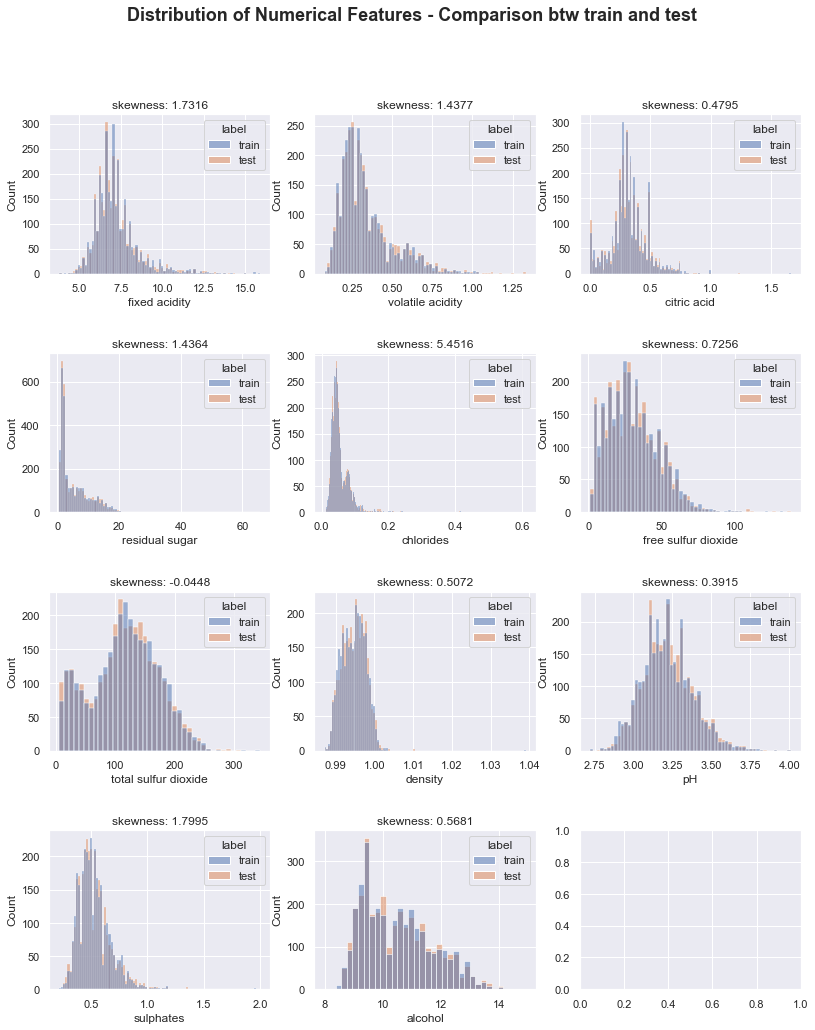

In [9]:
fig, axes = plt.subplots(4, 3, figsize = (12, 15), sharey=False)

for i, feature in enumerate(num_cols):
    sns.histplot(data = df, x = feature, hue = 'label', ax = axes[i//3][i%3])
    axes[i//3][i%3].set_title(f'skewness: {df[feature].skew():.4f}', fontsize = 12)
    plt.subplots_adjust(hspace = 0.5)
    
fig.suptitle('Distribution of Numerical Features - Comparison btw train and test', fontsize = 18,fontweight='bold')
plt.show()

<br>

### 범주형 변수 분포

train, test 데이터 간의 불균형은 없으나, red에 비해 white에 대한 비중이 3배 이상 높은 것으로 보입니다.



In [10]:
cat_col = 'type'
df2 = pd.concat([pd.DataFrame(train[cat_col]), pd.DataFrame(test[cat_col])])
df2['label'] = 'test'
df2['label'][:3231] = 'train'

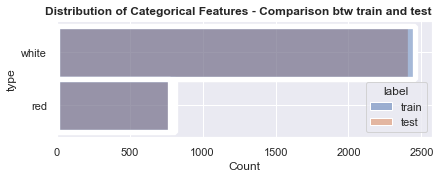

In [11]:
plt.figure(figsize = (6, 2))

sns.histplot(data = df2, y = 'type', hue = 'label')

plt.suptitle('Distribution of Categorical Features - Comparison btw train and test', fontsize = 12,fontweight='bold')
plt.show()

<br>

### 각 독립변수별 quality와의 관계 분석

각 변수들이 quality에 미치는 영향이 유의미한지를 확인해 보고자 합니다. 

<br>

In [12]:
# 피벗테이블 생성
def create_pivot(n):
    pivot_df = pd.pivot_table(data = train, index = 'quality', values = num_cols[n], aggfunc = ['mean', 'count'])
    pivot_df['ratio, %'] = round(pivot_df[('count', num_cols[n])] / len(train) * 100, 2)
    return pivot_df

# hist plot 생성
def create_plot(n):
    sns.histplot(data = train, x = num_cols[n], hue = 'quality', palette = 'colorblind')
    plt.show()

<br>

#### fixed acidity: 고정(비휘발성) 산도
+ 와인과 관련된 대부분의 산

<br>

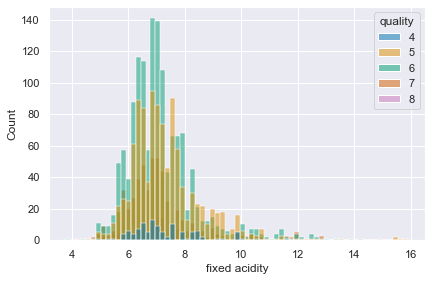

,mean,count,"ratio, %"
,fixed acidity,fixed acidity,
quality,,,
4,7.275926,108,3.34
5,7.339757,1069,33.09
6,7.161142,1418,43.89
7,7.127180,539,16.68
8,6.740206,97,3.00


None

In [13]:
display(create_pivot(0), create_plot(0))

<br>

#### volatile acidity : 휘발성 산도
+ 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

<br>

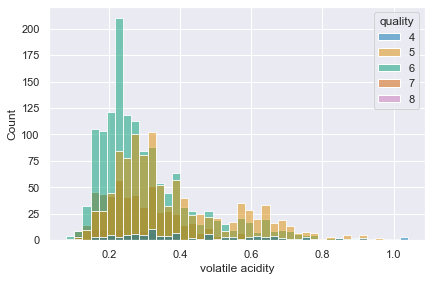

,mean,count,"ratio, %"
,volatile acidity,volatile acidity,
quality,,,
4,0.469028,108,3.34
5,0.383634,1069,33.09
6,0.309870,1418,43.89
7,0.292653,539,16.68
8,0.288196,97,3.00


None

In [14]:
display(create_pivot(1), create_plot(1))

<br>

#### citric acid : 구연산
+ 소량으로 발견되며, 와인에 풍미를 더할 수 있음

<br>

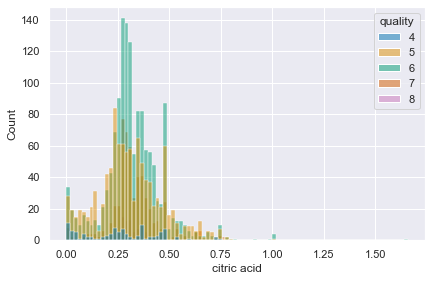

,mean,count,"ratio, %"
,citric acid,citric acid,
quality,,,
4,0.260926,108,3.34
5,0.313143,1069,33.09
6,0.323886,1418,43.89
7,0.331633,539,16.68
8,0.323093,97,3.00


None

In [15]:
display(create_pivot(2), create_plot(2))

<br>

#### residual sugar : 잔여 당분
+ 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

<br>

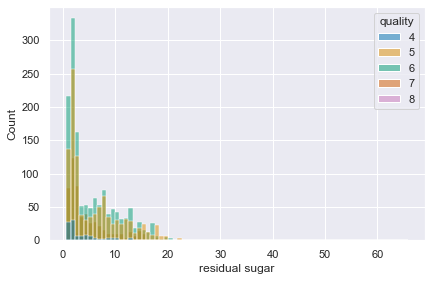

,mean,count,"ratio, %"
,residual sugar,residual sugar,
quality,,,
4,3.962037,108,3.34
5,5.889476,1069,33.09
6,5.548942,1418,43.89
7,4.679221,539,16.68
8,5.260309,97,3.00


None

In [16]:
display(create_pivot(3), create_plot(3))

<br>

#### chlorides: 염소화물
+ 와인의 염분량

<br>

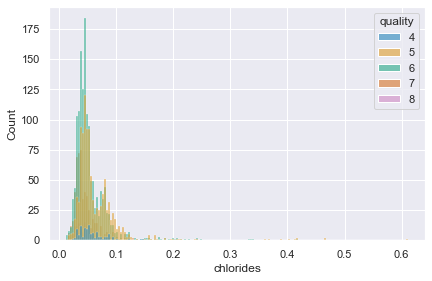

,mean,count,"ratio, %"
,chlorides,chlorides,
quality,,,
4,0.056972,108,3.34
5,0.064714,1069,33.09
6,0.054214,1418,43.89
7,0.045111,539,16.68
8,0.041825,97,3.00


None

In [17]:
display(create_pivot(4), create_plot(4))

<br>

#### free sulfur dioxide: 유리 이산화황
+ 미생물의 성장과 와인의 산화를 방지함

<br>

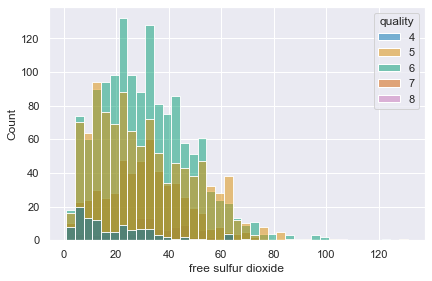

,mean,count,"ratio, %"
,free sulfur dioxide,free sulfur dioxide,
quality,,,
4,20.796296,108,3.34
5,30.526193,1069,33.09
6,30.960860,1418,43.89
7,30.725417,539,16.68
8,35.814433,97,3.00


None

In [18]:
display(create_pivot(5), create_plot(5))

<br>

#### total sulfur dioxide : 총 이산화황
+ 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

<br>

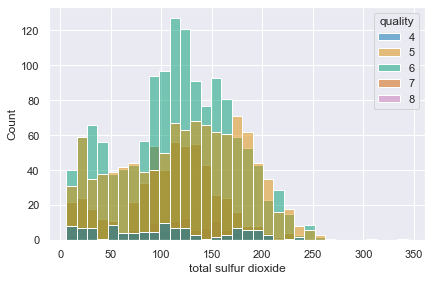

,mean,count,"ratio, %"
,total sulfur dioxide,total sulfur dioxide,
quality,,,
4,104.356481,108,3.34
5,121.696445,1069,33.09
6,115.722849,1418,43.89
7,108.591837,539,16.68
8,119.948454,97,3.00


None

In [19]:
display(create_pivot(6), create_plot(6))

<br>

#### density : 밀도
+ 알코올 및 당 함량에 따라 변함

<br>

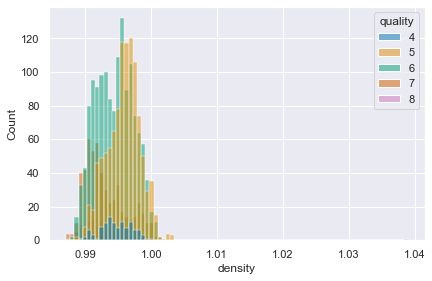

,mean,count,"ratio, %"
,density,density,
quality,,,
4,0.994770,108,3.34
5,0.995868,1069,33.09
6,0.994518,1418,43.89
7,0.993034,539,16.68
8,0.992576,97,3.00


None

In [20]:
display(create_pivot(7), create_plot(7))

<br>

#### pH : 산성 또는 염기성 정도
+ 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

<br>

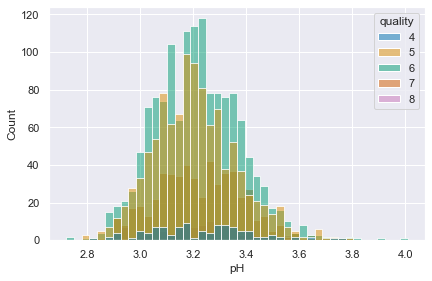

,mean,count,"ratio, %"
,pH,pH,
quality,,,
4,3.232870,108,3.34
5,3.204995,1069,33.09
6,3.213801,1418,43.89
7,3.225733,539,16.68
8,3.235464,97,3.00


None

In [21]:
display(create_pivot(8), create_plot(8))

<br>

#### sulphates : 황산염
+ 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

<br>

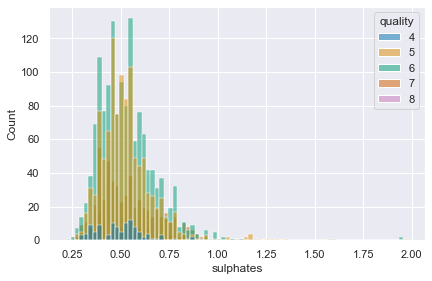

,mean,count,"ratio, %"
,sulphates,sulphates,
quality,,,
4,0.505833,108,3.34
5,0.529897,1069,33.09
6,0.531065,1418,43.89
7,0.542801,539,16.68
8,0.519794,97,3.00


None

In [22]:
display(create_pivot(9), create_plot(9))

<br>

#### alcohol : 와인의 알코올 함량. 백분율

<br>

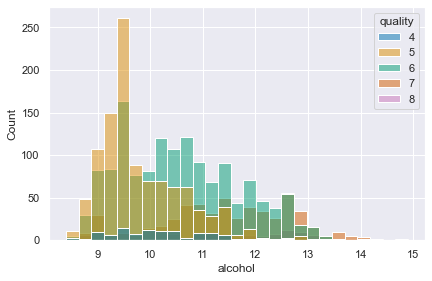

,mean,count,"ratio, %"
,alcohol,alcohol,
quality,,,
4,10.180556,108,3.34
5,9.846333,1069,33.09
6,10.578573,1418,43.89
7,11.445659,539,16.68
8,11.559794,97,3.00


None

In [23]:
display(create_pivot(10), create_plot(10))

<br>

#### type : 와인에 사용된 포도의 종류
+ Red(적포도주), White(백포도주)로 나뉨

<br>

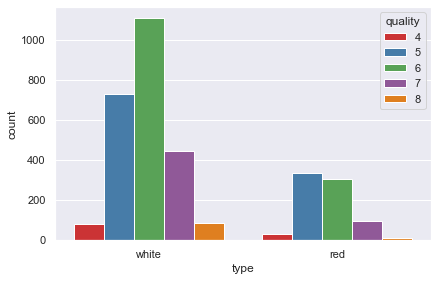

In [24]:
sns.countplot(data = train, x = 'type', hue = 'quality', palette = 'Set1')
plt.show()

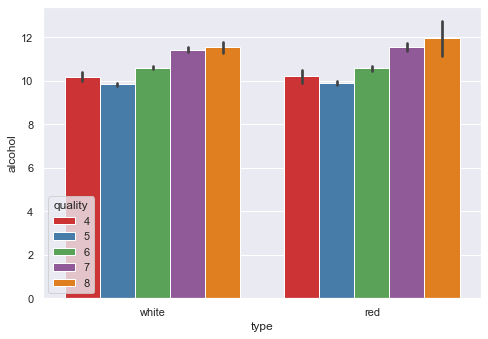

In [25]:
plt.figure(figsize=(7, 5))

sns.barplot(data = train, x = 'type', y = 'alcohol', hue = 'quality', palette = 'Set1')

plt.show()

<br>

#### 상관관계 분석

<br>

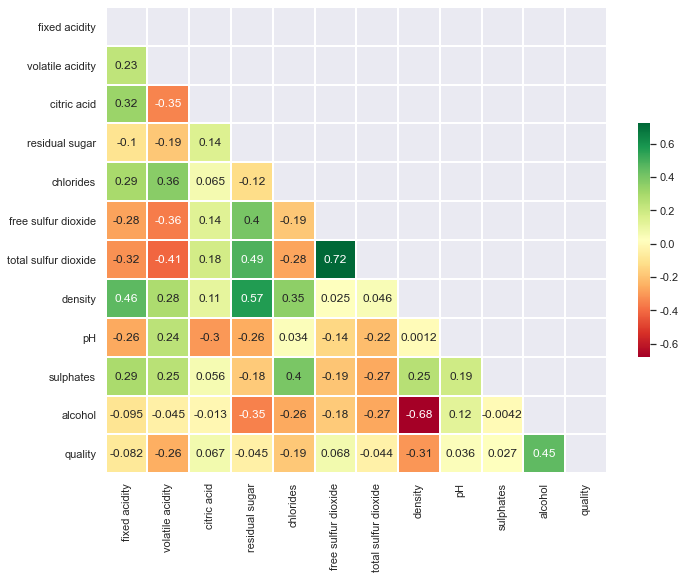

In [26]:
corr = train.corr()

plt.figure(figsize = (10, 8))

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

heat_map = sns.heatmap(corr,
                       annot = True,
                       cmap = 'RdYlGn',
                       mask = mask,
                       linewidths = 0.01,
                       cbar_kws = {'shrink' : .5})

<br>

**파생변수 생성 아이디어**

1. quality와 상관관계가 높은 변수들 확인
    + 그 변수의 분포를 확인 후 변수 내의 클래스 분포가 유의미하다면 해당 변수의 클래스별 통계량 변수 생성
    + 그 변수와 상관관계가 높은 다른 독립변수와의 곱셈 변수 생성
    + alcohol
        * quality와 0.45 양의 상관관계
        * type별, 클래스별 alcohol의 차이 확인
        
   
    
    
2. quality와 상관관계는 낮지만 서로 상관관계가 높은 독립변수들 확인
    + 파생변수 생성 방법은 위와 동일함
    + fixed acidity
        * 종속변수와 상관관계가 거의 없음
        * 양의 상관관계: density, citric acid, chlorides, sulphates



3. 아래의 기본 변수 이용 예측을 보면 6이 제일 많음에도 6의 precision이 낮은 편임. 6의 특징을 이용한 변수를 생성한다면 효과가 있을 것으로 판단됨


<br>

<br>

## Feature Engineering


In [27]:
dff = pd.DataFrame(columns=np.sort(train['quality'].unique()), index=num_cols)

mean_list = []

for i in range(4, 9):
    for col in num_cols:           
        value = train.loc[train['quality'] == i, col].mean()
        mean_list.append(value)
        
n = 11
mean_list = [mean_list[i*n : (i+1)*n] for i in range((len(mean_list) + n-1) // n)]

for i, j in zip(np.arange(0,5), np.arange(4, 9)):
    dff[j] = mean_list[i]
    
dff

,4,5,6,7,8
fixed acidity,7.275926,7.339757,7.161142,7.127180,6.740206
volatile acidity,0.469028,0.383634,0.309870,0.292653,0.288196
citric acid,0.260926,0.313143,0.323886,0.331633,0.323093
residual sugar,3.962037,5.889476,5.548942,4.679221,5.260309
chlorides,0.056972,0.064714,0.054214,0.045111,0.041825
free sulfur dioxide,20.796296,30.526193,30.960860,30.725417,35.814433
total sulfur dioxide,104.356481,121.696445,115.722849,108.591837,119.948454
density,0.994770,0.995868,0.994518,0.993034,0.992576
pH,3.232870,3.204995,3.213801,3.225733,3.235464
sulphates,0.505833,0.529897,0.531065,0.542801,0.519794


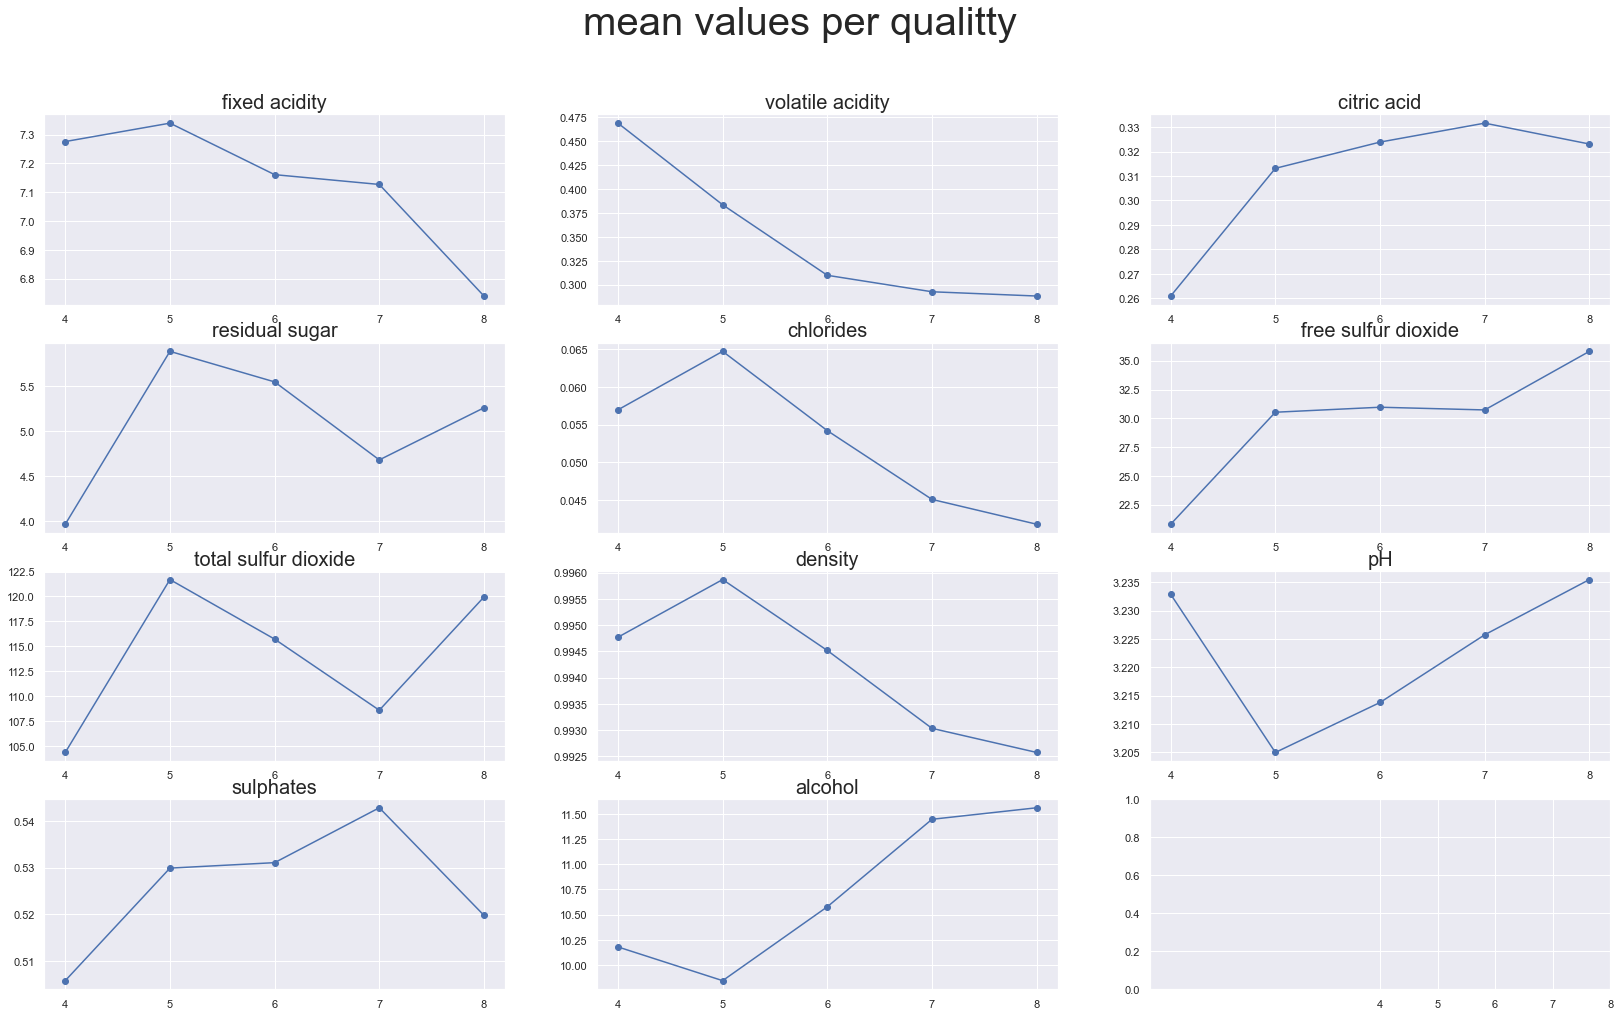

In [28]:
fig, axes = plt.subplots(4, 3, figsize=(25, 15))

fig.suptitle('mean values per qualitty', fontsize=40)
for ax, col in zip(axes.flat, dff.T.columns):
  ax.plot([4,5,6,7,8], dff.T[col])
  ax.scatter([4,5,6,7,8], dff.T[col])
  ax.set_title(col, fontsize=20)
plt.setp(axes, xticks=[4,5,6,7,8])
plt.show()

일단 데이터의 형태를 살펴봅니다.

dff는 인덱스가 변수들이고 각 컬럼이 타겟 변수의 클래스입니다.

In [69]:
dff

,4,5,6,7,8
fixed acidity,7.275926,7.339757,7.161142,7.127180,6.740206
volatile acidity,0.469028,0.383634,0.309870,0.292653,0.288196
citric acid,0.260926,0.313143,0.323886,0.331633,0.323093
residual sugar,3.962037,5.889476,5.548942,4.679221,5.260309
chlorides,0.056972,0.064714,0.054214,0.045111,0.041825
free sulfur dioxide,20.796296,30.526193,30.960860,30.725417,35.814433
total sulfur dioxide,104.356481,121.696445,115.722849,108.591837,119.948454
density,0.994770,0.995868,0.994518,0.993034,0.992576
pH,3.232870,3.204995,3.213801,3.225733,3.235464
sulphates,0.505833,0.529897,0.531065,0.542801,0.519794


<br>

### 집단시각화 과정


<br>

위의 그래프 12개 시각화를 하는 과정을 살펴보겠습니다.

집단 시각화가 아직 익숙치 않을 때에는 시험적으로 lineplot 등 그려보고자 하는 것을 하나의 변수만 이용해 시도해 봅니다.

시각화 목표는 x축에 타겟변수의 클래스가 나오고 y축에는 각 변수의 수치가 나오도록 하는 것입니다.

아래와 같이 시험적으로 시도할 시, 에러가 나게 되고 에러 메시지를 보면 다음과 같습니다.

"Length of Int64Index vectors must match length of `data` when both are used, but `data` has length 11 and the vector passed to `x` has length 5."

dff의 길이는 `len(dff)`로 확인하면 11입니다. 그러나 x축으로 보낸 `dff.columns`는 4부터 8까지의 5개 입니다.

이 둘이 달라서 그래프를 그릴 수 없다는 내용인데, 이 경우는 dff를 전치(transpose)하면 가능할 것으로 보입니다.

왜냐하면 `dff.T`로 전치하게 되면 데이터의 길이와 4,5,6,7,8 의 길이가 5로 동일해 지기 때문입니다.

이런 식으로, 에러 발생 시에는 데이터의 형태를 바꿔본다던지 하는 시도를 통해 해결할 수 있습니다.

In [86]:
# 오류 내용

sns.lineplot(data = dff, x = dff.columns)

ValueError: Length of Int64Index vectors must match length of `data` when both are used, but `data` has length 11 and the vector passed to `x` has length 5.

In [87]:
# dff를 전치하여 다시 dff로 할당

dff = dff.T
dff

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4,7.275926,0.469028,0.260926,3.962037,0.056972,20.796296,104.356481,0.994770,3.232870,0.505833,10.180556
5,7.339757,0.383634,0.313143,5.889476,0.064714,30.526193,121.696445,0.995868,3.204995,0.529897,9.846333
6,7.161142,0.309870,0.323886,5.548942,0.054214,30.960860,115.722849,0.994518,3.213801,0.531065,10.578573
7,7.127180,0.292653,0.331633,4.679221,0.045111,30.725417,108.591837,0.993034,3.225733,0.542801,11.445659
8,6.740206,0.288196,0.323093,5.260309,0.041825,35.814433,119.948454,0.992576,3.235464,0.519794,11.559794


<br>

전치한 후 다시 lineplot을 그려보면 아래와 같이 이상없이 출력됨을 확인할 수 있습니다.

다음으로 준비할 것은, 반복되는 구간이 있는지를 확인하는 것입니다.

* 총 11개의 독립변수가 있으므로 y에 0부터 10까지의 숫자를 보내면 dff.columns[숫자] 로 반복문을 통해 접근할 수 있을 것 같습니다. 또는 반복 시 사용하고자 하는 함수의 종류에 따라 접근 방법이 달라질 수 있는데요,
    * for문으로 그래프를 그릴때에는 range, zip, enumerate를 주로 사용하게 됩니다.
    * 이 경우 enumerate으로 기존에 만든 객체인 num_cols를 이용하면 0 : 'fixed acidity, 1 : 'volatile acidity 등등의 순서로 반환합니다.
    * 해당 숫자 키와 컬럼 명을 받아서 그래프를 그리는 것을 구현하겠습니다.
    

* 11개의 그래프가 필요하지만 집단시각화는 행렬 구조를 기초로 하므로, 일단 4 x 3 또는 3 x 4의 형태로 만든 뒤 맨 마지막에는 빈 그래프가 되도록 할 예정입니다.


* 여러 그래프를 동시에 그리므로 `plt.subplots`를 통해 구현할 것인데, 이 경우 그래프 그릴 시 `ax =` 옵션에 그래프 행렬의 열 갯수를 이용하여 각 그래프들의 위치를 전달할 수 있습니다. 또는 미리 `axes`를 flatten하여 더욱 간결하게 할 수도 있습니다.

<br>

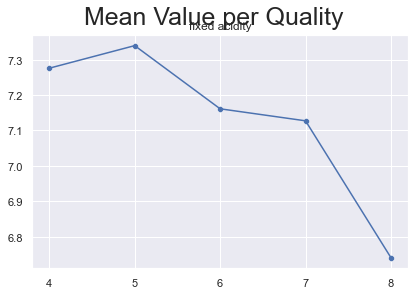

In [112]:
# 일단 연습삼아 하나만 그래프를 그리고 여러 속성들을 추가해보면서 집단시각화에서 반복할 것들에 대한 감을 잡습니다.

ax = sns.lineplot(data = dff, x = dff.index, y = dff.columns[0])
sns.scatterplot(data = dff, x = dff.index, y = dff.columns[0])

ax.set_title(dff.columns[0])
ax.set(ylabel=None)
ax.set_xticks(range(4, 9))
plt.subplots_adjust(hspace=0.5)

plt.show()

<br>

위 연습한 것을 기초로 `enumerate`를 이용하여 집단시각화를 표현해 보겠습니다.

`enumerate` 에 num_cols 객체를 넣으면 {0 : 'fixed acidity, 1 : 'volatile acidity 등등}의 순서로 반환한다고 했는데요,

여기서 숫자(순서)를 i로, 컬럼명을 col로 받아서 반복문을 돌립니다.

각 그래프함수의 인자에 해당하는 `ax=` 는 그래프가 그려질 위치를 나타냅니다. 일정한 규칙을 갖고 위치 배치를 하도록 인덱싱 순서를 설정합니다.

최초에 axes는 4 x 3의 행렬이므로, `axes[0][0]` 은 제일 좌 상단에 위치하고 `axes[0][1]`은 가운데 제일 상단에 위치하는 이런 식입니다.

`//`는 몫이고, `%`는 나머지를 반환하는 연산이므로, 예를 들어 i = 4가 들어왔다면 `axes[i//3][i%3]`은 `axes[1][1]`이 되어 두번째 줄의 가운데에 위치하게 됩니다.

<br>

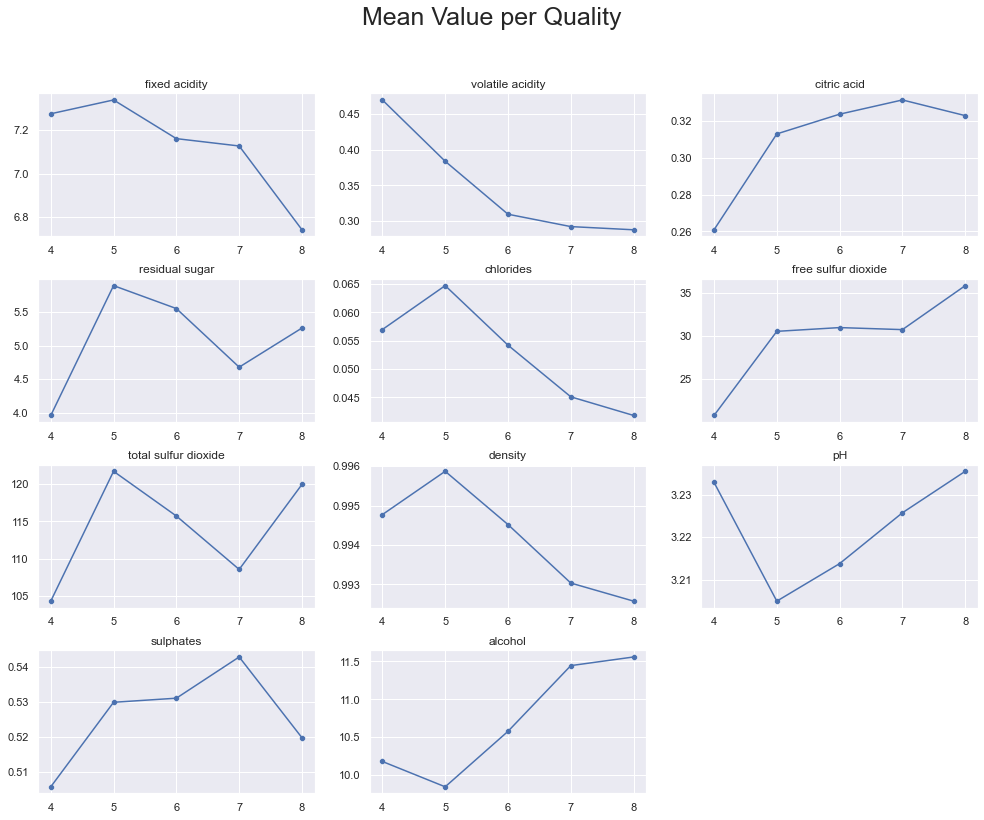

In [141]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))

for i, col in enumerate(num_cols):
    sns.lineplot(data = dff, x = dff.index, y = col, ax = axes[i//3][i%3])
    sns.scatterplot(data = dff, x = dff.index, y = col, ax = axes[i//3][i%3])
    axes[i//3][i%3].set_title(col)
    axes[i//3][i%3].set(ylabel=None)  # 기존에 y축에 있던 레이블 이름을 제거
    plt.subplots_adjust(hspace=0.3, wspace=0.2)  # subplot들의 간격 설정

axes[3][2].axis('off') # 사용하지 않는 마지막 그래프를 미출력하여 깔끔하게 나오도록
plt.suptitle('Mean Value per Quality', fontsize = 25)  # 전체 제목
plt.show()

<br>

`enumerate` 대신에 `zip`을 이용하여 복잡한 나누기 연산을 통한 인덱싱보다 깔끔하게 구현 가능합니다.

기존의 4 x 3 행렬 구조인 axes를 `flatten()`으로 벡터화하여 순서대로 전달하는 것입니다.

`zip` 함수는 마치 두 개의 김밥을 써는 것과 같습니다. `num_cols`객체의 첫번째인 `'fixed acidity'`와 `axes`의 첫번째 공간을 함께 반환하여 이들을 이용해 순서대로 반복문을 수행하며 자리배치를 합니다.

<br>

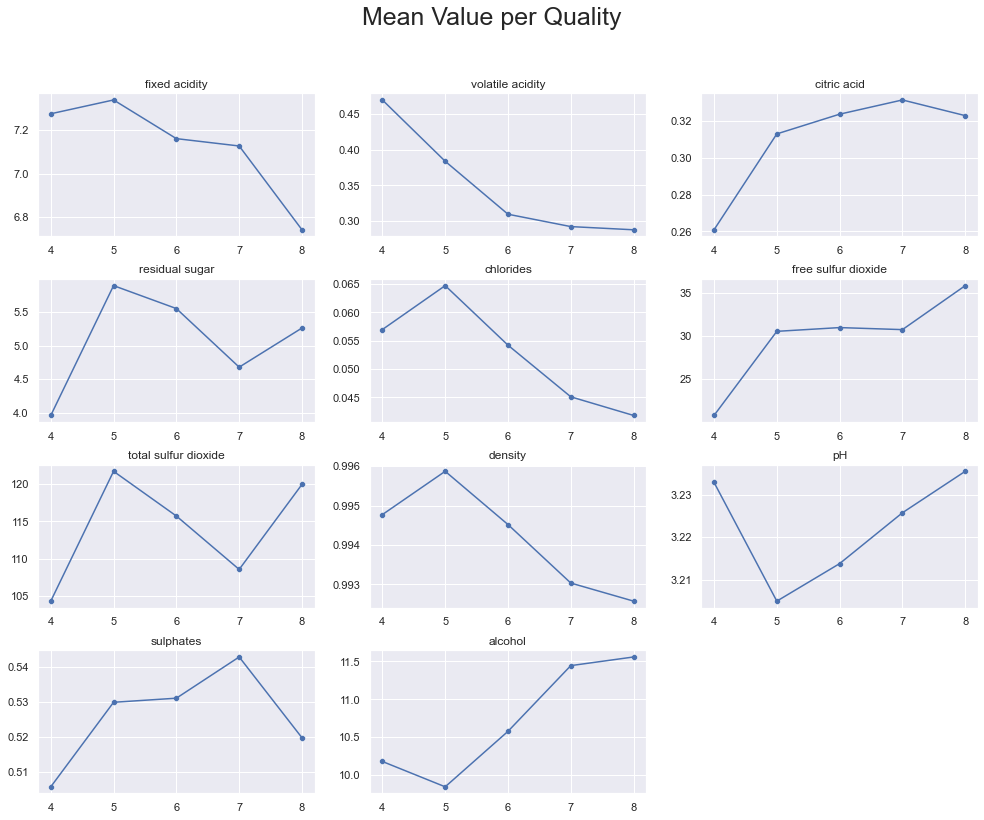

In [142]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
    sns.lineplot(data = dff, x = dff.index, y = col, ax = ax)
    sns.scatterplot(data = dff, x = dff.index, y = col, ax = ax)
    ax.set_title(col)
    ax.set(ylabel=None)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

axes[-1].axis('off')  # flatten했으므로 행렬타입의 인덱싱 대신 리스트 인덱싱 방식으로 처리
plt.suptitle('Mean Value per Quality', fontsize = 25)
plt.show()

<br><br>

### 파생변수 생성

* 상관관계와 집단시각화를 통해 'qualtiy'별로 변수의 특징을 살펴 보았고 이를 토대로 여러 파생변수들을 생성해 실험해 보았습니다.


* 주석처리된 것들은 내부 평가에서 오히려 성능이 나빠져서 삭제하였습니다.


* 주의사항: 생성한 파생변수는 수치형 변수이므로 향후 scaling 시에 기존의 num_cols에 꼭 함께 포함시켜야 함

In [266]:
train['alc_positive'] = train['alcohol'] * train['pH']
test['alc_positive'] = test['alcohol'] * test['pH']

train['sulfurs'] = train['free sulfur dioxide'] * train['total sulfur dioxide']
test['sulfurs'] = test['free sulfur dioxide'] * test['total sulfur dioxide']

train['good_acid'] = train['fixed acidity'] - train['volatile acidity']
test['good_acid'] = test['fixed acidity'] - test['volatile acidity']

train['citric_ratio'] = train['citric acid'] / train['fixed acidity']
test['citric_ratio'] = test['citric acid'] / test['fixed acidity']

train['freesulf_ratio'] = train['free sulfur dioxide'] / train['total sulfur dioxide']
test['freesulf_ratio'] = test['free sulfur dioxide'] / test['total sulfur dioxide']

train['positive_corr'] = train['citric acid'] + train['free sulfur dioxide'] + train['pH'] + train['sulphates'] + train['alcohol']
test['positive_corr'] = test['citric acid'] + test['free sulfur dioxide'] + test['pH'] + test['sulphates'] + test['alcohol']

train['pH2'] = train['pH']**2
test['pH2'] = test['pH']**2

train['sulf_ratio'] = train['sulphates'] / train['total sulfur dioxide']
test['sulf_ratio'] = test['sulphates'] / test['total sulfur dioxide']



# train['vola_vs_citric'] =  train['citric acid'] / train['volatile acidity']
# test['vola_vs_citric'] =  test['citric acid'] / test['volatile acidity']

# train['total_acid'] = train['fixed acidity'] + train['volatile acidity'] + train['citric acid']
# test['total_acid'] = test['fixed acidity'] + test['volatile acidity'] + test['citric acid']

# train['fixed_volatile'] = train['fixed acidity'] / train['volatile acidity']
# test['fixed_volatile'] = test['fixed acidity'] / test['volatile acidity']

# train['dens_sugar'] = train['density'] * train['residual sugar']
# test['dens_sugar'] = test['density'] * test['residual sugar']

In [191]:
## 효과없는 변수는 바로 제거

# train.drop(['vola_vs_citric'], axis=1, inplace=True)
# test.drop(['vola_vs_citric'], axis=1, inplace=True)

<br>

## 데이터 전처리

* type 변수: one-hot encoding으로 더미변수화
* numeric 변수: standard scaling으로 centering


In [267]:
# one-hot encoding

train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

display(train_df.shape, train_df.head(1), test_df.shape, test_df.head(1))

(3231, 22)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alc_positive,sulfurs,good_acid,citric_ratio,freesulf_ratio,positive_corr,pH2,sulf_ratio,type_red,type_white
id,,,,,,,,,,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.04,15.0,96.0,0.9912,3.06,0.61,12.1,6,37.026,1440.0,7.82,0.04625,0.15625,31.14,9.3636,0.006354,0,1


(3231, 21)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,alc_positive,sulfurs,good_acid,citric_ratio,freesulf_ratio,positive_corr,pH2,sulf_ratio,type_red,type_white
id,,,,,,,,,,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.9,0.37,11.1,32.19,4140.0,6.99,0.034247,0.217391,44.62,8.41,0.002681,0,1


In [268]:
# 기존의 num_cols에는 파생변수가 없으므로 num_cols 객체를 재 정의함

num_cols = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'alc_positive',
 'sulfurs',
 'good_acid',
 'citric_ratio',
           'freesulf_ratio',
            'positive_corr',
            'pH2',
            'sulf_ratio',
           ]

In [269]:
# standard scaling to make the numeric variables standardized

ss = StandardScaler()

for col in num_cols:
    train_df[col] = ss.fit_transform(train_df[[col]])
    test_df[col] = ss.fit_transform(test_df[[col]])
    
display(train_df.head(2), test_df.head(2))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alc_positive,sulfurs,good_acid,citric_ratio,freesulf_ratio,positive_corr,pH2,sulf_ratio,type_red,type_white
id,,,,,,,,,,,,,,,,,,,,,,
1,0.613164,-0.973871,0.346320,-0.862826,-0.444893,-0.896417,-0.363344,-1.135570,-0.952533,0.524814,1.342873,6,0.745286,-0.753837,0.749666,0.084913,-1.049217,-0.815209,-0.944920,-0.171422,0,1
2,0.227151,0.274102,-0.202257,-0.115217,-0.976867,0.426604,-0.058413,-1.443438,-0.828960,-0.343803,2.096877,7,1.433699,0.010368,0.197455,-0.301242,0.420371,0.564820,-0.828119,-0.361793,0,1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,alc_positive,sulfurs,good_acid,citric_ratio,freesulf_ratio,positive_corr,pH2,sulf_ratio,type_red,type_white
id,,,,,,,,,,,,,,,,,,,,,
1,0.063011,-0.191206,-0.470589,0.258118,-0.707904,-0.022119,0.403475,-0.775939,-2.026277,-1.089432,0.515259,-0.372110,-0.017801,0.089194,-0.513805,-0.564290,-0.018777,-1.929464,-0.499301,0,1
2,1.146747,2.162839,-0.539777,-0.624624,5.007836,-1.470535,-1.770665,1.489262,0.613957,0.462904,-1.248324,-0.901551,-1.119611,0.885880,-0.853940,0.356269,-1.571497,0.592391,2.572829,1,0


<br>

## 모델 생성

* train_test_split
* k-fold cross validation
* creating lgbm classifier
* model evaluation


In [270]:
X_trn = train_df.drop(['quality'], axis=1).reset_index(drop=True)
y_trn = train_df['quality'].reset_index(drop=True)
X_tst = test_df.reset_index(drop=True)

display(X_trn.shape, y_trn.shape, X_tst.shape)

(3231, 21)

(3231,)

(3231, 21)

<br>

### 모델 생성 및 성능평가

<br>

In [271]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 25
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_lgb = []
mean_acc = 0

model_lgb = LGBMClassifier(objective = 'multiclass', random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_lgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'logloss',
             early_stopping_rounds = 100)
    
    y_preds = model_lgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_lgb.append(model_lgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6308
Fold 1's score: 0.6231
Fold 2's score: 0.6308
Fold 3's score: 0.6692
Fold 4's score: 0.6308
Fold 5's score: 0.6462
Fold 6's score: 0.5736
Fold 7's score: 0.6434
Fold 8's score: 0.6202
Fold 9's score: 0.6202
Fold 10's score: 0.5504
Fold 11's score: 0.6357
Fold 12's score: 0.6667
Fold 13's score: 0.6279
Fold 14's score: 0.5736
Fold 15's score: 0.6434
Fold 16's score: 0.6279
Fold 17's score: 0.6434
Fold 18's score: 0.6977
Fold 19's score: 0.7054
Fold 20's score: 0.6977
Fold 21's score: 0.6667
Fold 22's score: 0.5116
Fold 23's score: 0.6279
Fold 24's score: 0.6434
Mean auc of all folds: 0.6323


In [32]:
model_lgb.feature_importances_

array([ 514, 1005,  592, 1128,  897,  283,  834,  956,  876, 1030,  822,
        921,  636,  936,  928, 1025,  723,    0,  878,    9,    7])

In [272]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 25
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_xgb = []
mean_acc = 0

model_xgb = XGBClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_xgb.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'mlogloss',
             early_stopping_rounds = 100)
    
    y_preds = model_xgb.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_xgb.append(model_xgb.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6308
Fold 1's score: 0.6308
Fold 2's score: 0.5923
Fold 3's score: 0.6769
Fold 4's score: 0.6308
Fold 5's score: 0.6462
Fold 6's score: 0.6202
Fold 7's score: 0.6512
Fold 8's score: 0.6512
Fold 9's score: 0.6512
Fold 10's score: 0.5814
Fold 11's score: 0.6589
Fold 12's score: 0.6822
Fold 13's score: 0.6434
Fold 14's score: 0.5814
Fold 15's score: 0.6434
Fold 16's score: 0.6822
Fold 17's score: 0.5581
Fold 18's score: 0.6512
Fold 19's score: 0.6744
Fold 20's score: 0.7287
Fold 21's score: 0.6822
Fold 22's score: 0.5426
Fold 23's score: 0.6822
Fold 24's score: 0.6434
Mean auc of all folds: 0.6407


In [273]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 25
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_rf = []
mean_acc = 0

model_rf = RandomForestClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_rf.fit(X_train, y_train)
    
    y_preds = model_rf.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_rf.append(model_rf.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6615
Fold 1's score: 0.6692
Fold 2's score: 0.6385
Fold 3's score: 0.7077
Fold 4's score: 0.6385
Fold 5's score: 0.6769
Fold 6's score: 0.6279
Fold 7's score: 0.6589
Fold 8's score: 0.6202
Fold 9's score: 0.6512
Fold 10's score: 0.6357
Fold 11's score: 0.6279
Fold 12's score: 0.6667
Fold 13's score: 0.6434
Fold 14's score: 0.5969
Fold 15's score: 0.6667
Fold 16's score: 0.6977
Fold 17's score: 0.6047
Fold 18's score: 0.6667
Fold 19's score: 0.6589
Fold 20's score: 0.6977
Fold 21's score: 0.6512
Fold 22's score: 0.5814
Fold 23's score: 0.6667
Fold 24's score: 0.6744
Mean auc of all folds: 0.6515


In [274]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 25
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_et = []
mean_acc = 0

model_et = ExtraTreesClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_et.fit(X_train, y_train)
    
    y_preds_et = model_et.predict(X_val)
    score = accuracy_score(y_val, y_preds_et)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_et.append(model_et.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6692
Fold 1's score: 0.6538
Fold 2's score: 0.6615
Fold 3's score: 0.7231
Fold 4's score: 0.6615
Fold 5's score: 0.6769
Fold 6's score: 0.6202
Fold 7's score: 0.6822
Fold 8's score: 0.6279
Fold 9's score: 0.5969
Fold 10's score: 0.6124
Fold 11's score: 0.6279
Fold 12's score: 0.6667
Fold 13's score: 0.6589
Fold 14's score: 0.5891
Fold 15's score: 0.6589
Fold 16's score: 0.6744
Fold 17's score: 0.6279
Fold 18's score: 0.6977
Fold 19's score: 0.7132
Fold 20's score: 0.6667
Fold 21's score: 0.6822
Fold 22's score: 0.5581
Fold 23's score: 0.6512
Fold 24's score: 0.6822
Mean auc of all folds: 0.6536


In [69]:
print(classification_report(y_val, y_preds_et))

              precision    recall  f1-score   support

           4       1.00      0.20      0.33         5
           5       0.74      0.67      0.71        43
           6       0.62      0.82      0.71        56
           7       0.77      0.45      0.57        22
           8       1.00      0.67      0.80         3

    accuracy                           0.68       129
   macro avg       0.83      0.56      0.62       129
weighted avg       0.71      0.68      0.67       129



4를 기준으로 classification report를 해석하면 다음과 같다

1. precision(정밀도): 4라고 예측한 것들 중 실제로 4일 확률 --> 다른 클래스와 큰 차이가 없다
2. recall(재현율): 4인 것들 중 실제로 4로 예측된 확률 --> 유독 4를 맞추는 게 어렵다
3. F1(정밀도와 재현율의 가중조화평균): 4를 맞추는 게 어렵다

<br>

<br>

#### VotingClassifier를 이용한 ensemble 

[참고 블로그](https://yganalyst.github.io/ml/ML_chap6-1/)

* 위에서 학습한 4개 모델을 **`VotingClassifier`**에 인자로 넣어 학습


* `voting`옵션은 `'hard'`와 `'soft'`가 있으며, 둘 다 해 본 결과 `'hard'`가 좀 더 나은 결과를 보였음

In [300]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 25
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds_vote = []
mean_acc = 0

model_vote = VotingClassifier(estimators=[('lgb', model_lgb),
                                          ('xgb', model_xgb),
                                          ('rf', model_rf),
                                          ('et', model_et)],
                              voting = 'hard')

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model_vote.fit(X_train, y_train)
    
    y_preds_vote = model_vote.predict(X_val)
    score = accuracy_score(y_val, y_preds_vote)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score:.4f}")
        
    preds_vote.append(model_vote.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits:.4f}")

Fold 0's score: 0.6462
Fold 1's score: 0.6385
Fold 2's score: 0.6077
Fold 3's score: 0.6615
Fold 4's score: 0.6462
Fold 5's score: 0.6923
Fold 6's score: 0.6434
Fold 7's score: 0.6667
Fold 8's score: 0.6357
Fold 9's score: 0.6434
Fold 10's score: 0.5736
Fold 11's score: 0.6357
Fold 12's score: 0.6667
Fold 13's score: 0.6589
Fold 14's score: 0.5891
Fold 15's score: 0.6512
Fold 16's score: 0.6667
Fold 17's score: 0.6202
Fold 18's score: 0.6822
Fold 19's score: 0.6899
Fold 20's score: 0.7209
Fold 21's score: 0.6667
Fold 22's score: 0.5271
Fold 23's score: 0.6667
Fold 24's score: 0.6667
Mean auc of all folds: 0.6465


<br>

## Hyper Parameter Optimization using OPTUNA


<br>

### lgbm HPO

In [304]:
# def lgb_objective(trial):
#     params = {
#         'boosting_type': 'rf',
#         'objective': 'multiclass',
#         'n_estimators': trial.suggest_int("n_estimators", 64, 8192),
#         'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1),
#         'num_leaves': trial.suggest_int("num_leaves", 20, 3000),
#         'max_depth': trial.suggest_int("max_depth", 3, 12),
#         'feature_fraction': trial.suggest_float("feature_fraction", 0.1, 1.0),
#         'min_gain_to_split' : trial.suggest_int('min_gain_to_split', 0, 15),
#         'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 100, 1000),
#         'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 1.0),
#         'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 1.0),
#         'bagging_fraction' : trial.suggest_float("bagging_fraction", 0, 0.8),
#         'bagging_freq' : trial.suggest_int("bagging_freq", 1, 100),
#         'deterministic': True,
#         'verbose':-1
#     }
    
    
    
#     RANDOM_SEED = 42
#     n_splits = 10
#     skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)
#     model_lgb = LGBMClassifier(**params)
#     score = cross_val_score(model_lgb, X_trn, y_trn, scoring = 'accuracy', cv=skf)
#     score = score.mean()
    
    
    
#     return score

In [307]:
# sampler = TPESampler(seed = 42)
# study = optuna.create_study(study_name = 'lgbm_hpo',
#                            direction = 'maximize',
#                             pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=5),
#                            sampler = sampler)
# study.optimize(lgb_objective, n_trials = 20)

# print("Best acc:", study.best_value)
# print("Best params:", study.best_params)

In [2]:
# params_lgb = study.best_params
# params_lgb

In [3]:
# # k-fold cross validation, trial with the tuned parameters.


# RANDOM_SEED = 42
# n_splits = 10
# skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

# preds_lgb = []
# mean_acc = 0

# model_lgb = LGBMClassifier(**params_lgb)

# for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
#     X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
#     y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
#     model_lgb.fit(X_train, y_train,
#              verbose = False,
#              eval_set = [(X_train, y_train), (X_val, y_val)],
#              eval_metric = 'multi_logloss',
#              early_stopping_rounds = 100)
    
#     y_preds = model_lgb.predict(X_val)
#     score = accuracy_score(y_val, y_preds)
#     mean_acc += score
    
#     print(f"Fold {fold}'s score: {score}")
        
#     preds_lgb.append(model_lgb.predict(X_tst))

# print("==========================================")
# print(f"Mean acc of all folds: {mean_acc / n_splits}")

<br>

### [xgb HPO](https://linuxtut.com/en/70343a93899f42382765/)

In [36]:
# def xgb_objective(trial):
#     params = {
#         'eta': trial.suggest_loguniform("eta", 1e-8, 1.0),
#         'gamma': trial.suggest_loguniform("gamma", 1e-8, 1.0),
#         'n_estimators': trial.suggest_int("n_estimators", 30, 1000),
#         'max_depth': trial.suggest_int("max_depth", 1, 20),
#         'min_child_weight': trial.suggest_loguniform("min_child_weight", 1e-8, 1.0),
#         'max_delta_step': trial.suggest_loguniform("max_delta_step", 1e-8, 1.0),
#         'subsample': trial.suggest_uniform("subsample", 0.0, 1.0),
#         'reg_lambda': trial.suggest_uniform("reg_lambda", 0.0, 1000.0),
#         'reg_alpha': trial.suggest_uniform("reg_alpha", 0.0, 1000.0)
#     }
    
    
    
#     RANDOM_SEED = 42
#     n_splits = 10
#     skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)
#     model_xgb = XGBClassifier(**params)
#     score = cross_val_score(model_xgb, X_trn, y_trn, scoring = 'accuracy', cv=skf)
#     score = score.mean()
    
    
    
#     return score

In [1]:
# sampler = TPESampler(seed = 42)
# study = optuna.create_study(study_name = 'xgb_hpo',
#                            direction = 'maximize',
#                             pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=5),
#                            sampler = sampler)
# study.optimize(xgb_objective, n_trials = 20)

# print("Best acc:", study.best_value)
# print("Best params:", study.best_params)

In [2]:
# params_xgb = study.best_params
# params_xgb

In [3]:
# # k-fold cross validation, trial with the tuned parameters.


# RANDOM_SEED = 42
# n_splits = 10
# skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

# preds_xgb = []
# mean_acc = 0

# model_xgb = XGBClassifier(**params_xgb)

# for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
#     X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
#     y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
#     model_xgb.fit(X_train, y_train)
    
#     y_preds = model_xgb.predict(X_val)
#     score = accuracy_score(y_val, y_preds)
#     mean_acc += score
    
#     print(f"Fold {fold}'s score: {score}")
        
#     preds_xgb.append(model_xgb.predict(X_tst))

# print("==========================================")
# print(f"Mean acc of all folds: {mean_acc / n_splits}")

<br>

### [RandomForest HPO](https://linuxtut.com/en/3bdae8c1098ced2dea5f/)

In [36]:
# def rf_objective(trial):
#     params = {
#         'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy']),
#         'bootstrap': trial.suggest_categorical("bootstrap", [True, False]),
#         'n_estimators': trial.suggest_int("n_estimators", 30, 1000),
#         'max_depth': trial.suggest_int("max_depth", 1, 10000),
#         'max_features': trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2']),
#         'max_leaf_nodes': trial.suggest_int("max_leaf_nodes", 1, 10000)
#     }
    
    
    
#     RANDOM_SEED = 42
#     n_splits = 10
#     skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)
#     model_rf = RandomForestClassifier(**params)
#     score = cross_val_score(model_rf, X_trn, y_trn, scoring = 'accuracy', cv=skf)
#     score = score.mean()
    
    
    
#     return score

In [1]:
# sampler = TPESampler(seed = 42)
# study = optuna.create_study(study_name = 'rf_hpo',
#                            direction = 'maximize',
#                             pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=5),
#                            sampler = sampler)
# study.optimize(rf_objective, n_trials = 20)

# print("Best acc:", study.best_value)
# print("Best params:", study.best_params)

In [2]:
# params_rf = study.best_params
# params_rf

In [3]:
# # k-fold cross validation, trial with the tuned parameters.


# RANDOM_SEED = 42
# n_splits = 10
# skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

# preds_rf = []
# mean_acc = 0

# model_rf = RandomForestClassifier(**params_rf)

# for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
#     X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
#     y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
#     model_rf.fit(X_train, y_train)
    
#     y_preds = model_rf.predict(X_val)
#     score = accuracy_score(y_val, y_preds)
#     mean_acc += score
    
#     print(f"Fold {fold}'s score: {score}")
        
#     preds_rf.append(model_rf.predict(X_tst))

# print("==========================================")
# print(f"Mean acc of all folds: {mean_acc / n_splits}")

<br>

### [ExtraTrees HPO](https://www.kaggle.com/infof4221wang/top2-0-808612-featureengineer-optuna-treemodel)

In [60]:
def et_objective(trial):
    params = {
        'criterion': trial.suggest_categorical("criterion", ['gini', 'entropy']),
        'n_estimators': trial.suggest_int("n_estimators", 30, 100, 10),
        'max_depth': trial.suggest_int("max_depth", 1, 200, 10),
        'min_samples_split': trial.suggest_int("min_samples_split", 20, 200),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 20, 200)
    }
    
        
    RANDOM_SEED = 42
    n_splits = 10
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)
    model_et = ExtraTreesClassifier(**params)
    score = cross_val_score(model_et, X_trn, y_trn, scoring = 'accuracy', cv=skf)
    score = score.mean()
    
        
    return score

In [61]:
sampler = TPESampler(seed = 42)
pruner = optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=5)

study = optuna.create_study(study_name = 'et_hpo',
                           direction = 'maximize',
                            pruner = pruner,
                           sampler = sampler)
study.optimize(et_objective, n_trials = 20)

print("Best acc:", study.best_value)
print("Best params:", study.best_params)

[I 2021-12-04 01:55:29,051] A new study created in memory with name: et_hpo
[I 2021-12-04 01:55:29,903] Trial 0 finished with value: 0.5400861904215877 and parameters: {'criterion': 'entropy', 'n_estimators': 80, 'max_depth': 111, 'min_samples_split': 48, 'min_samples_leaf': 48}. Best is trial 0 with value: 0.5400861904215877.
[I 2021-12-04 01:55:30,531] Trial 1 finished with value: 0.4784925276153347 and parameters: {'criterion': 'entropy', 'n_estimators': 70, 'max_depth': 141, 'min_samples_split': 23, 'min_samples_leaf': 195}. Best is trial 0 with value: 0.5400861904215877.
[I 2021-12-04 01:55:30,938] Trial 2 finished with value: 0.5054122233688797 and parameters: {'criterion': 'gini', 'n_estimators': 40, 'max_depth': 31, 'min_samples_split': 75, 'min_samples_leaf': 114}. Best is trial 0 with value: 0.5400861904215877.
[I 2021-12-04 01:55:31,632] Trial 3 finished with value: 0.5171769292512326 and parameters: {'criterion': 'gini', 'n_estimators': 70, 'max_depth': 21, 'min_samples_spl

Best acc: 0.5515374765890761
Best params: {'criterion': 'entropy', 'n_estimators': 100, 'max_depth': 161, 'min_samples_split': 97, 'min_samples_leaf': 20}


In [51]:
# params_et = study.best_params
# params_et

In [235]:
# # k-fold cross validation, trial with the tuned parameters.


# RANDOM_SEED = 42
# n_splits = 20
# skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

# preds_et = []
# mean_acc = 0

# model_et = ExtraTreesClassifier(**params_et)

# for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
#     X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
#     y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
#     model_et.fit(X_train, y_train)
    
#     y_preds = model_et.predict(X_val)
#     score = accuracy_score(y_val, y_preds)
#     mean_acc += score
    
#     print(f"Fold {fold}'s score: {score}")
        
#     preds_et.append(model_et.predict(X_tst))

# print("==========================================")
# print(f"Mean acc of all folds: {mean_acc / n_splits}")

<br>

## 예측 및 제출

In [275]:
# preds_all = preds_et + preds_lgb + preds_xgb + preds_rf

# len(preds_all)

100

In [301]:
preds = np.mean(preds_vote, axis = 0)

final_preds = np.round(preds).astype('int64')

In [302]:
submission = pd.read_csv('./dataset/sample_submission.csv')

submission['quality'] = final_preds

In [303]:
submission.to_csv('./dataset/submission_12.csv', index=False)